# PulseInputDDM neural model tutorial

This is a not very detailed detailed crash course in using this code to fit the classic "Bing's model" to neural and choice data. Things you can learn:

- How to load your data
- How to plot some PSTHs, grouped by evidence strength
- How to fit the model
- How to save results

`using` is the julia version of python's `import`, i.e. in incorporates the exported functions of a module into the current namespace. `Distributed` is a julia module for performing parallel computing. `addprocs()` adds some workers, which can be called by a main process if there are calls to do things in parallel. `PulseInputDDM` parallelizes the computation of the log-likelhood across trials.

In [1]:
using Distributed
addprocs(8);

In [3]:
using PulseInputDDM

## Load your data

To load youre data you are going to use the `load_neural_data` function.
In Julia, multiple functions can have the same name (called multiple dispatch). Julia's compiler decides which function to use depending on the inputs. Every function with that name you query will be listed below.

Define a path to where the data you want to fit is located. 

See [this page](https://brody-lab.github.io/PulseInputDDM.jl/README.md/) for the expected format for `.MAT` files if one were fitting the choice model. In addition to those fields, for a neural model `rawdata` should also contain an  extra field:

- `rawdata.spike_times`: cell array containing the spike times of each neuron on an individual trial. The cell array will be length of the number of neurons recorded on that trial. Each entry of the cell array is a column vector containing the relative timing of spikes, in seconds. Zero seconds is the start of the click stimulus. Spikes before and after the click inputs should also be included.

The convention for fitting the neural model is that each session should have its own `.MAT` file. (This constrasts with the convetion for the choice model, where a single `.MAT` file can contain data from different session). It's just easier this way, especially if different sessions have different number of cells.

In [4]:
files = ["./data/T103_303075.mat", "./data/T103_304258.mat"];

In [5]:
data, μ_rnt, _ = load_neural_data(files, pad=20, filtSD=5);

In [5]:
ncells, ntrials = map(x-> x[1].ncells, data), length.(data)

([4, 2], [461, 457], 4)

In [8]:
nconds = 2

(2, 0.01, 53)

In [9]:
output = PulseInputDDM.process_spike_data.(μ_rnt, data; nconds=nconds);

μ_ct = getindex.(output, 1)
σ_ct = getindex.(output, 2);

## Plot your data

Here's some pretty basic Julia code for taking a look at the cells you're about to analyze. My most simple type of plot is to group trials into `nconds` number of groups based on the total amount of evidence, and plot the average firing rate as a function of time for those two groups.

In [10]:
using PyPlot

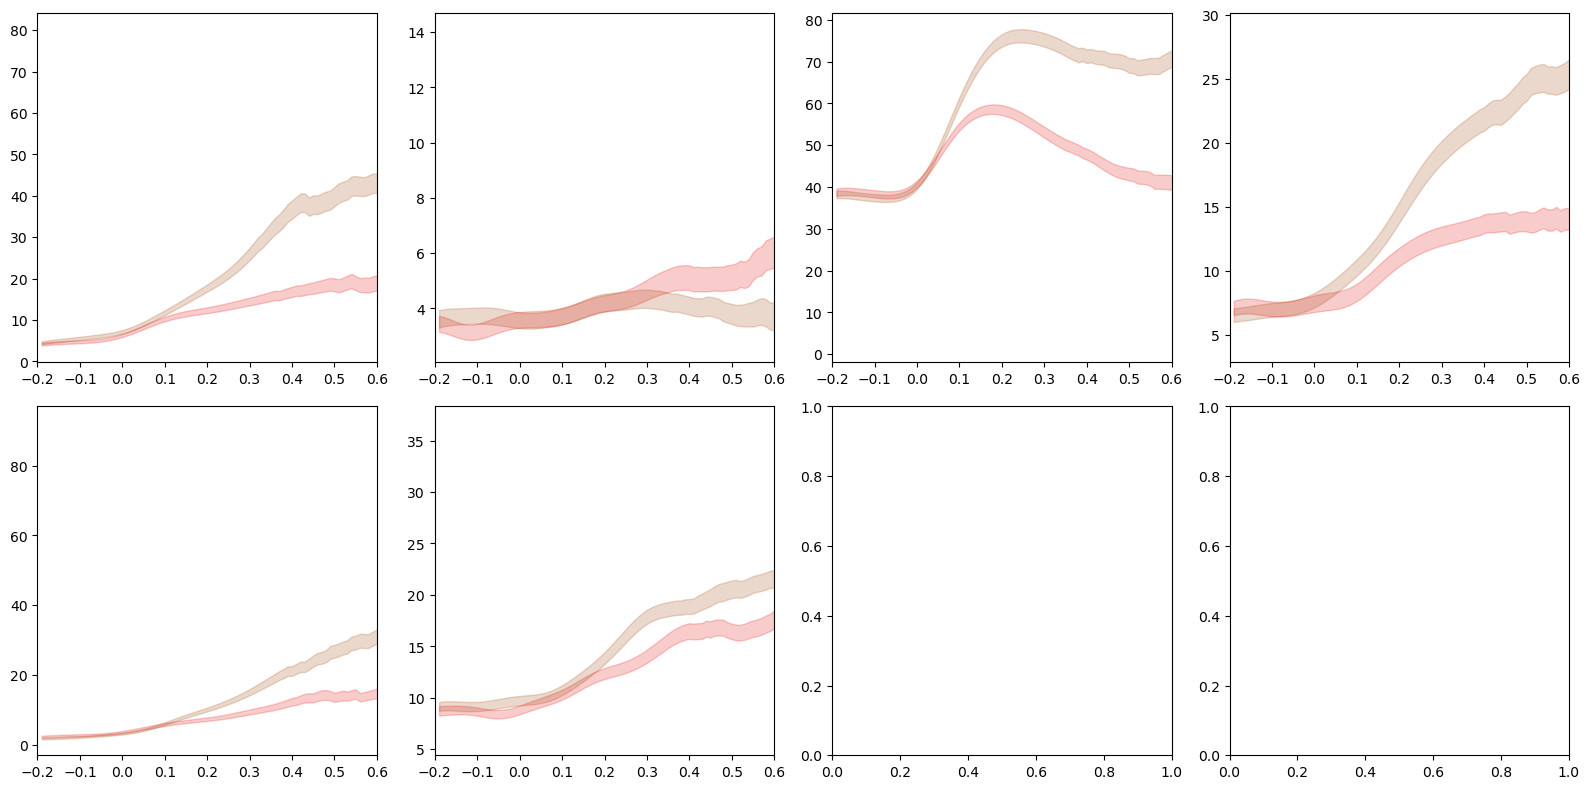

In [11]:
num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]

for i in 1:num_rows      
    for j in 1:data[i][1].ncells   
        
        if (num_rows == 1) && (data[i][1].ncells == 1)
        
            for k = 1:nconds   

                ax.fill_between((1:length(μ_ct[i][j][k]))*dt .-0.2,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k])                                   

                ax[i,j].set_xlim((-0.2, 0.6))

            end   
            
        elseif (num_rows == 1) && (data[i][1].ncells > 1)
            
            for k = 1:nconds   

                ax[j].fill_between((1:length(μ_ct[i][j][k]))*dt .-0.2,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k])                                  

                ax[i,j].set_xlim((-0.2, 0.6))

            end   

        elseif num_rows > 1
             
            for k = 1:nconds   

                ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt .-0.2,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k])                                   

                ax[i,j].set_xlim((-0.2, 0.6))

            end   
            
        end

    end
    
end

tight_layout()
display(gcf())

## Fit the model

For the neural model, we need to decide the form of the non-linear function between the accumulator and the spikes.

`f`: the tuning curve between a(t) and the expected firing rate. There are two options here, `Sigmoid` and `Softplus`. `Softplus` is simpler, and thus faster to fit, with less concern of overfitting.
    
It's possibe to assign different forms to differnet neurons. As such `f` should be an `array`, with one element for each session. Each element is another `array`, each elemnt of which is a `string` for the tuning curve choice for each neuron.

`all_Softplus(data)` will make a softplus for every neuron.

In [12]:
f = all_Softplus(data)

2-element Vector{Vector{String}}:
 ["Softplus", "Softplus", "Softplus", "Softplus"]
 ["Softplus", "Softplus"]

In [13]:
model = θy0(data, f)

noiseless_neuralDDM{θneural_noiseless{θz{Float64}, Vector{Vector{Softplus{Float64}}}}}
  θ: θneural_noiseless{θz{Float64}, Vector{Vector{Softplus{Float64}}}}


In [14]:
x0 = vcat([0.1, 20., -0.1, 20., 0.8, 0.8, 0.008], 
    PulseInputDDM.flatten(model.θ)[dimz+1:end]);
options = neural_options(f)  
θ = θneural(x0, f)
model = neuralDDM(θ=θ)

neuralDDM{θneural{θz{Float64}, Vector{Vector{Softplus{Float64}}}}}
  θ: θneural{θz{Float64}, Vector{Vector{Softplus{Float64}}}}
  n: Int64 53
  cross: Bool false


In [15]:
model, = fit(model, data, options)

Fminbox
-------
Initial mu = 0.0113349

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.0113349

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.214329e+05     9.804548e+02
 * time: 0.016000032424926758

Exiting inner optimizer with x = [0.17084813667231383, 20.03838312665876, 0.17472390553069075, 20.010919904713365, 1.1073396364611419, 0.8096947561378681, 0.988437654136551, 1.794071215088175, -0.5170348309870548, 1.3160105968377804, 0.6296483483338112, 1.3215694601175332, 0.34684126428651296]
Current distance to box: 0.0115623
Decreasing barrier term μ.



(neuralDDM{θneural{θz{Float64}, Vector{Vector{Softplus{Float64}}}}}
  θ: θneural{θz{Float64}, Vector{Vector{Softplus{Float64}}}}
  n: Int64 53
  cross: Bool false
,  * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.211557e+05

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 1.61e+00 ≰ 1.0e-10
    |x - x'|/|x'|          = 5.65e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 1.0e-09
    |g(x)|                 = 2.98e+01 ≰ 1.0e-03

 * Work counters
    Seconds run:   68  (vs limit 170000)
    Iterations:    1
    f(x) calls:    3
    ∇f(x) calls:   3
)

## Sample rates

In [16]:
_, μ_c_λ, = simulate_expected_firing_rate(model, data; num_samples=20, nconds=nconds);

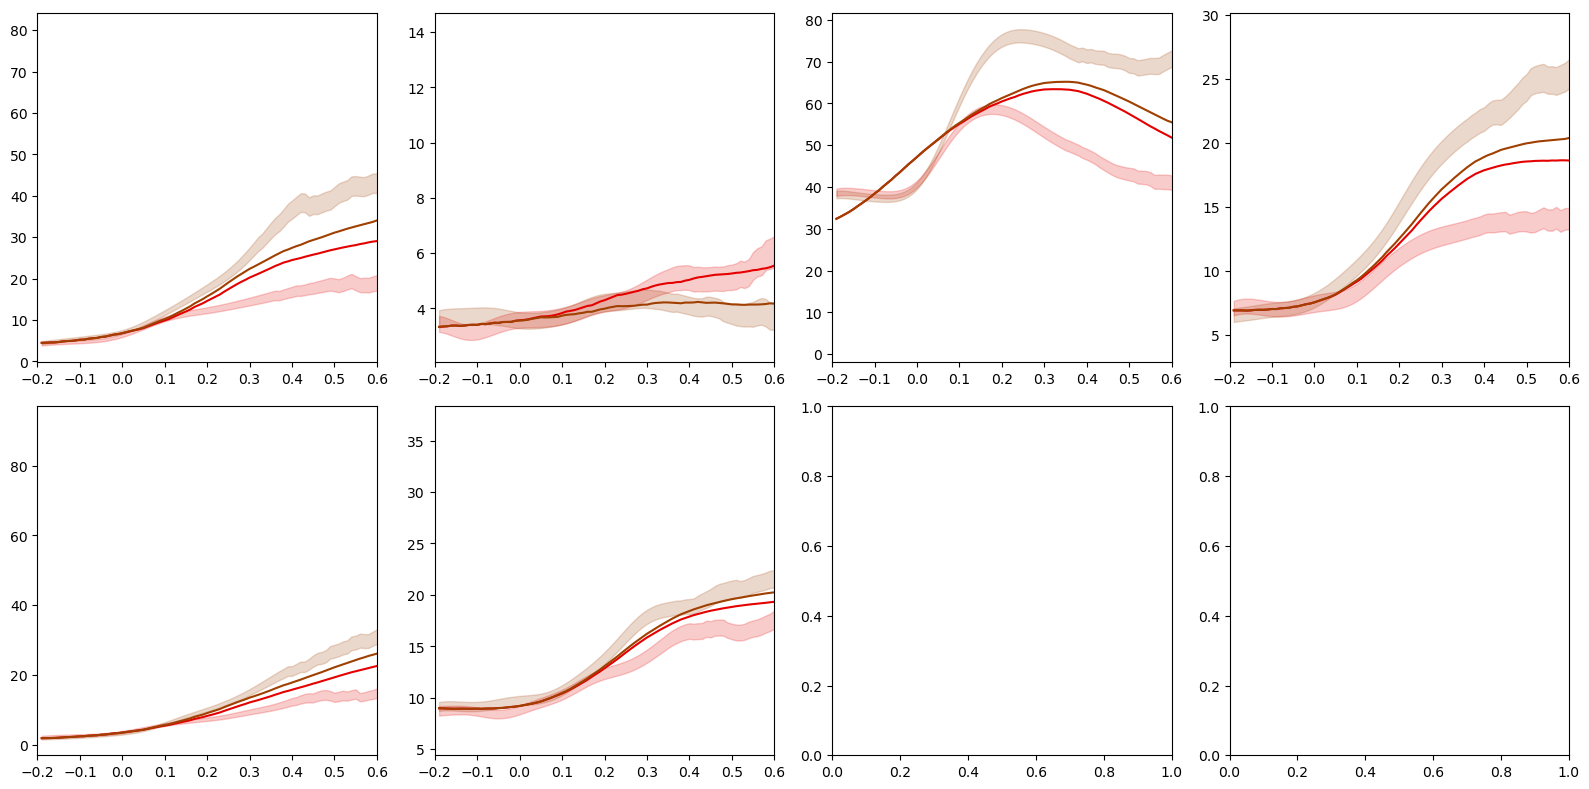

In [17]:
num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]

for i in 1:num_rows      
    for j in 1:data[i][1].ncells   
        
        if (num_rows == 1) && (data[i][1].ncells == 1)
        
            for k = 1:nconds   

                ax.fill_between((1:length(μ_ct[i][j][k]))*dt .-0.2,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k]) 
                
                ax.plot((1:length(μ_c_λ[i][j][k]))*dt .-0.2,
                    μ_c_λ[i][j][k], color=my_colors[k])  

                ax[i,j].set_xlim((-0.2, 0.6))

            end   
            
        elseif (num_rows == 1) && (data[i][1].ncells > 1)
            
            for k = 1:nconds   

                ax[j].fill_between((1:length(μ_ct[i][j][k]))*dt .-0.2,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k])  
                
                ax[j].plot((1:length(μ_c_λ[i][j][k]))*dt .-0.2,
                    μ_c_λ[i][j][k], color=my_colors[k])  

                ax[i,j].set_xlim((-0.2, 0.6))

            end   
            
        elseif num_rows > 1
             
            for k = 1:nconds   

                ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt .-0.2,
                    μ_ct[i][j][k] + σ_ct[i][j][k],
                    μ_ct[i][j][k] - σ_ct[i][j][k],
                    alpha=0.2, color=my_colors[k]) 
                
                ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt .-0.2,
                    μ_c_λ[i][j][k], color=my_colors[k])  

                ax[i,j].set_xlim((-0.2, 0.6))

            end   
            
        end

    end
    
end

tight_layout()
display(gcf())

## Save your results

This section, and the one below, will walk you through the basics of saving the output of the model fitting procedure, so you can reload it later.

In [18]:
file = joinpath("./data", "example_model.mat");
save_neural_model(file, model, data, options)

## Reloading some saved stuff

In [22]:
θ, options, n, cross = reload_neural_model(file)

(θneural{θz{Float64}, Vector{Vector{Softplus{Float64}}}}
  θz: θz{Float64}
  θy: Array{Vector{Softplus{Float64}}}((2,))
  f: Array{Vector{String}}((2,))
, neural_options
  fit: Array{Bool}((13,)) Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  ub: Array{Float64}((13,)) [30.0, 30.0, 5.0, 100.0, 2.5, 1.2, 1.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
  lb: Array{Float64}((13,)) [0.0, 4.0, -5.0, 0.0, 0.0, 0.01, 0.005, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0]
, 53, false, 0.01, 0, 20)

Reconstruct the `neuralDDM` model with the outputs of `reload_neural_model`

In [25]:
model = neural_choiceDDM(θ=θ)

neural_choiceDDM{θneural{θz{Float64}, Vector{Vector{Softplus{Float64}}}}}
  θ: θneural{θz{Float64}, Vector{Vector{Softplus{Float64}}}}
  n: Int64 53
  cross: Bool false
